In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
data_path = f'/content/gdrive/My Drive/Object Localization'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def getBB(file):
  
  #parse the annotations
  path = data_path + f'/annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = data_path + f'/images/{file[:-4]}.jpg' 
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.figure(figsize=(9,9))
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((190, 61), (450, 304))


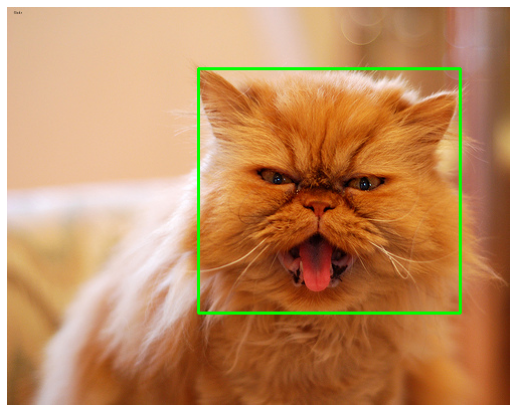

In [4]:
file = np.random.choice(os.listdir(data_path + f'/annotations/xmls'))
drawBB(file)

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
      img_path = data_path + f'/images/{f[:-4]}.jpg'
      img = Image.open(img_path)
      w,h = img.size
      
      img = img.resize(sz)
      (xmin, ymin), (xmax, ymax) = getBB(f)
      
      img = np.array(img).astype('float32')
      if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)

      else:
        img = img[:,:,0:3]
      
      box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

      batch_x.append(img/255)
      batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

In [6]:
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))

Size of training  3501
Size of testing   185


In [0]:
x, y = next(train_generator)

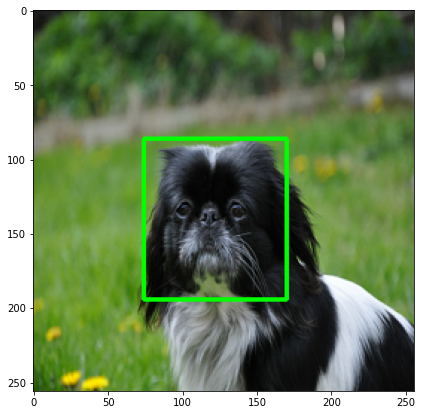

In [8]:
img = (x[0] * 255).astype('uint8')
box = y[0]
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.figure(figsize=(7,7))
plt.imshow(annotated)

**Keras ImageDataGenerator**

```
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
```

```
def append_ext(file):
    return file[:-4] + ".jpg"

traindf = pd.DataFrame()
traindf['id'] = train_files
# traindf["label"] = traindf["id"].apply(getBB)
# traindf["id"] = traindf["id"].apply(append_ext)

testdf = pd.DataFrame()
testdf['id'] = test_files
# testdf["label"] = testdf["id"].apply(getBB)
# testdf["id"] = testdf["id"].apply(append_ext)
```

```

# Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

data_dir = data_path + f'/images'
train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=data_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    target_size=(150, 150), # Resizes all images to 150 × 150
                                                    batch_size=20,
                                                    class_mode='binary') # Class mode needs to be changed

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf,
                                                  directory=data_dir,
                                                  x_col="id",
                                                  y_col="label",
                                                  target_size=(150, 150), # Resizes all images to 150 × 150
                                                  batch_size=20,
                                                  class_mode='binary')
```





# Evaluation Metric

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d

https://venuktan.wordpress.com/2018/03/02/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow/

In [0]:
def iou(tb1, tb2):
  x11, y11, x12, y12 = tf.split(tb1, 4, axis=1)
  x21, y21, x22, y22 = tf.split(tb2, 4, axis=1)

  xA = tf.maximum(x11, tf.transpose(x21))
  yA = tf.maximum(y11, tf.transpose(y21))
  xB = tf.minimum(x12, tf.transpose(x22))
  yB = tf.minimum(y12, tf.transpose(y22))

  interArea = tf.maximum((xB - xA + 1), 0) * tf.maximum((yB - yA + 1), 0)

  boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
  boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)

  iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)

  return iou

# Create the Model

**Functional API**

https://machinelearningmastery.com/keras-functional-api-deep-learning/

https://keras.io/guides/functional_api/

**Callbacks**

https://keras.io/api/callbacks/

https://keras.io/api/callbacks/model_checkpoint/


**Keras Conv2D**

https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/


**Batch vs Epoch**

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [0]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(inp)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(pool2)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool3)
pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool4)
pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)

conv6 = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(pool5)
pool6 = MaxPooling2D(pool_size = (2, 2))(conv6)

flatten = Flatten()(pool6)
dense1 = Dense(128, activation = 'relu')(flatten)
drop1  = Dropout(0.5)(dense1)
out = Dense(4, activation = 'sigmoid')(drop1)

model = tf.keras.models.Model(inputs = inp, outputs = out)
model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = [iou])

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

# Training



In [12]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator,
                    epochs = 30,
                    steps_per_epoch = train_steps,
                    validation_data = test_generator,
                    validation_steps = test_steps,
                    callbacks=[model_save])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
109/109 [==============================] - 334s 3s/step - loss: 0.0268 - iou: 0.7015 - val_loss: 0.0243 - val_iou: 0.7098
Epoch 2/30
109/109 [==============================] - 332s 3s/step - loss: 0.0235 - iou: 0.7161 - val_loss: 0.0216 - val_iou: 0.7252
Epoch 3/30
109/109 [==============================] - 326s 3s/step - loss: 0.0232 - iou: 0.7147 - val_loss: 0.0219 - val_iou: 0.7144
Epoch 4/30
109/109 [==============================] - 329s 3s/step - loss: 0.0209 - iou: 0.7126 - val_loss: 0.0188 - val_iou: 0.7071
Epoch 5/30
109/109 [==============================] - 325s 3s/step - loss: 0.0179 - iou: 0.7023 - val_loss: 0.0125 - val_iou: 0.7138
Epoch 6/30
109/109 [==============================] - 327s 3s/step - loss: 0.0158 - iou: 0.6913 - val_loss: 0.0113 - val_iou: 0.6957
Epoch 7/30
109/109 [==============================] - 322s 3s/step - loss: 0.0138 - iou: 0.6851 - val_loss: 0.0086 - val_iou: 

# Prediction

In [0]:
#load the best model 
model.load_weights('best_model.h5')

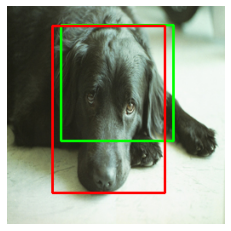

In [14]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))